# TOV Emulator to train a PIRNN to predict mass and radius of a Neutron Strar from a PP EOS

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

%matplotlib widget

### <div style= 'color: goldenrod'> Global constants and unit conversion factors

In [2]:
msun=147660                 # Solar mass in cm given by the formula G*M_sun/c^2

c=2.9979e10                 # speed of light in cm/s (CGS)
G=6.67408e-8                # gravitational constant in cm^3/gm/s^2 (CGS)

dkm = 1.3234e-06            # conversion of MeV/fm^3 to km^-2
dcgs = 1.78e12              # factor to convert from MeV/fm^3 to gm/cm^3
conv = 8.2601e-40           # dyn/cm^2 to km^-2
cgs1=1.7827e+12             # MeV/fm3 to gms/cm3
cgs2=1.6022e+33             # MeV/fm3 to dyne/cm2

### <div style= 'color: goldenrod'> Piecewise-polytrope low-density (crust) parameters

In [3]:
# Polytropic exponents
GammaL_1 = 1.35692
GammaL_2 = 0.62223
GammaL_3 = 1.28733
GammaL_4 = 1.58425

# Polytropic constants
KL_1 = 3.99874e-8 # * pow(Msun/Length**3, GammaL_1-1)
KL_2 = 5.32697e+1 # * pow(Msun/Length**3, GammaL_2-1)
KL_3 = 1.06186e-6 # * pow(Msun/Length**3, GammaL_3-1)
KL_4 = 6.80110e-9 # * pow(Msun/Length**3, GammaL_4-1)
# notice a missing c^2 in Ki values in Table II of Read et al. 2009

# Densities at the boundaries of the piecewise polytropes
rhoL_1 = 2.62789e12
rhoL_2 = 3.78358e11
rhoL_3 = 2.44034e7
rhoL_4 = 0.0

# Pressures at the boundaries of the piecewise polytropes
pL_1 = KL_1*rhoL_1**GammaL_1
pL_2 = KL_2*rhoL_2**GammaL_2
pL_3 = KL_3*rhoL_3**GammaL_3
pL_4 = 0.0

# The exact numbers are taken from a particular crust model/table.

### <div style= 'color: goldenrod'> Few more calculations

In [4]:
# Compute the offsets specific internal energy (epsL_i) and alphaL_i at the boundaries
# The general form used: ε(ρ)=(1+α)ρ+K/(Γ−1)ρ^Γ. Solving for alpha ensures matching across boundaries.
# Energy density needs an additive offset to enforce continuity.

epsL_4 = 0.0
alphaL_4 = 0.0
epsL_3 = (1+alphaL_4)*rhoL_3 + KL_4/(GammaL_4 - 1.)*pow(rhoL_3, GammaL_4)
alphaL_3 = epsL_3/rhoL_3 - 1.0 - KL_3/(GammaL_3 - 1.)*pow(rhoL_3, GammaL_3 -1.0)
epsL_2 = (1+alphaL_3)*rhoL_2 + KL_3/(GammaL_3 - 1.)*pow(rhoL_2, GammaL_3)
alphaL_2 = epsL_2/rhoL_2 - 1.0 - KL_2/(GammaL_2 - 1.)*pow(rhoL_2, GammaL_2 -1.0)
epsL_1 = (1+alphaL_2)*rhoL_1 + KL_2/(GammaL_2 - 1.)*pow(rhoL_1, GammaL_2)
alphaL_1 = epsL_1/rhoL_1 - 1.0 - KL_1/(GammaL_1 - 1.)*pow(rhoL_1, GammaL_1 -1.0)

# Density thresholds for high-density polytropes
rho1 = pow(10,14.7) # Break Density
rho2 = pow(10,15.0) # Break Density

# GR conversion prefactors to go from cgs pressure/energy-density units into geometric units (where G=c=1)
t_p=G/c**4
t_rho=G/c**2

### <div style= 'color: goldenrod'> Forward EOS: ρ↦(p,ε)

In [5]:
def p_eps_of_rho(rho,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1)) 
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    if rho<rhoL_3:
        p = KL_4*pow(rho,GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2:
        p = KL_3*pow(rho,GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        p = KL_2*pow(rho,GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        p = KL_1*pow(rho,GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        p = K1*pow(rho,Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        p = K2*pow(rho,Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        p = K3*pow(rho,Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return p*c**2, eps*c**2

### <div style= 'color: goldenrod'> Inverse EOS: p↦ε

In [6]:
@jit(nopython=True)
def eps(p,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    p*=1/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1))
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    p0 = K1*pow(rho0,Gamma1)
    p2 = K3*pow(rho2,Gamma3)
    if  p<pL_3:
        rho = pow(p/KL_4,1/GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif pL_3<= p <pL_2:
        rho = pow(p/KL_3,1/GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif pL_2<= p <pL_1:
        rho = pow(p/KL_2,1/GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif  pL_1<p <p0:
        rho = pow(p/KL_1,1/GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif p0<= p <p1:
        rho = pow(p/K1,1/Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif p1<= p <p2:
        rho = pow(p/K2,1/Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        rho = pow(p/K3,1/Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return eps*c**2

### <div style= 'color: goldenrod'> The TOV Integrator

In [7]:
def TOV(logrho_c,theta):
    seq=[]
    logp,Gamma1,Gamma2,Gamma3 = theta[0],theta[1],theta[2],theta[3]
    dr=100
    rho_c = pow(10,logrho_c)
    m=0.0
    r=0.1
    p,e = p_eps_of_rho(rho_c,theta[0],theta[1],theta[2],theta[3])
    p*=t_p
    e*=t_p
       
    while p >= 0:
        p += -(e+p)*(m+4.0*np.pi*(r**3.0)*p)*dr/(r*(r-2.0*m))
        if p <= 0:
            break               
        m += 4.0*np.pi*(r**2.0)*e*dr
        r += dr
        e = eps(p/t_p,theta[0],theta[1],theta[2],theta[3])*t_p
            
    return  m/msun,r/1e5

### <div style= 'color: goldenrod'> Produce a mass-radius curve for a single EOS

Text(0, 0.5, '$M \\, (M_{\\odot})$')

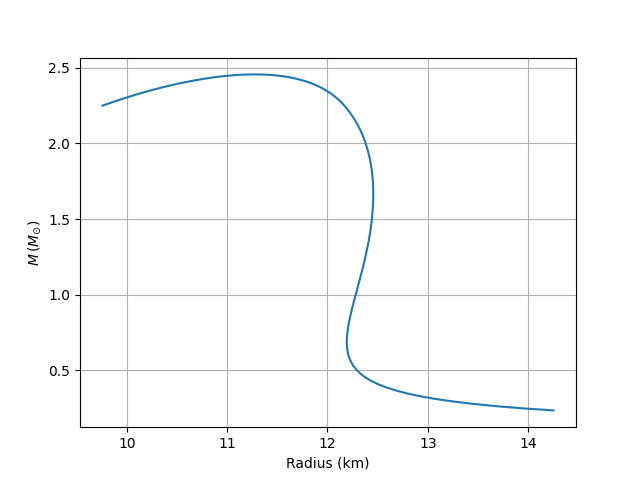

In [8]:
logrho_c_array=np.linspace(14.5,15.4,100)
theta=[34.495, 3.446, 3.572, 2.887] #MPA1

seq=[]
for logrho_c in logrho_c_array:
    m,r=TOV(logrho_c,theta)
    seq.append((m,r))
    
seq=np.vstack(seq)

plt.plot(seq[:,1],seq[:,0])
plt.grid()
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')

### <div style= 'color: slateblue'>Create dataset of EOS parameter samples & run TOV to create targets

In [9]:
# Number of EOS samples
num_samples = 1000 

EOS_params = np.random.uniform(low=[1.4, 1.4], 
                                   high=[5., 5.], 
                                   size=(num_samples, 2))

# Sample central pressure values (in dyn/cm²)
logrho_c_samples = np.random.uniform(low=14.5, high=15.4, size=(num_samples, 1))

# Placeholder for Mass, Radius, Tidal Deformability
MR_data = []

# Generate dataset
for i in range(num_samples):
    logrho_c = logrho_c_samples[i, 0]
    params = EOS_params[i]
    M,R = TOV(logrho_c,[34.495, 3.446,params[0],params[1]])
    MR_data.append([M,R])

# Convert to NumPy array
EOS_data = np.hstack([logrho_c_samples, EOS_params, np.array(MR_data)])

# Save dataset
np.save("EOS_dataset.npy", EOS_data)

In [10]:
np.shape(EOS_data)  # Should be (num_samples, 5)

(1000, 5)

In [11]:
# Checking the dataset with added column headers
Column_headers = ['log_rho_c', 'Gamma2', 'Gamma3', 'Mass_Msun', 'Radius_km']
import pandas as pd
df = pd.DataFrame(EOS_data, columns=Column_headers)
df.head()

,log_rho_c,Gamma2,Gamma3,Mass_Msun,Radius_km
0,14.642626,3.906075,2.574352,0.553459,12.237001
1,14.774678,4.916564,3.974358,1.295170,12.494001
2,15.106356,3.409002,3.077476,2.357833,11.612001
3,14.925600,3.292699,4.797992,1.756115,12.320001
4,15.048946,2.496572,2.082242,1.638076,11.704001


### <div style= 'color: goldenrod'> PyTorch ML pipeline — load & prepare data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load("EOS_dataset.npy")
print(data[1:10])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to pytorch tensors
X = torch.tensor(data[ : , :3], dtype=torch.float32)  # log_rho_c,  Gamma2, Gamma3
y = torch.tensor(data[ : , 3:5], dtype=torch.float32)  # Mass, Radius

# Compute mean and std on the full dataset
X_mean, X_std = X.mean(dim=0), X.std(dim=0)
y_mean, y_std = y.mean(dim=0), y.std(dim=0)

# Normalize the dtatset
X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Split into training and validation sets
train_size = int(0.8 * len(X_norm))
X_train, X_val = X_norm[:train_size], X_norm[train_size:]
y_train, y_val = y_norm[:train_size], y_norm[train_size:]

# Reshape the tensors for dataloader
X_train, y_train = X_train.view(-1, 3), y_train.view(-1, 2)
X_val, y_val = X_val.view(-1, 3), y_val.view(-1, 2)

[[14.96425542  3.4715254   2.37108459  2.02248576 12.295001  ]
 [14.61824436  3.52038004  3.62379396  0.48162232 12.324001  ]
 [14.59327258  3.95488962  4.28627731  0.41616619 12.481001  ]
 [14.67819384  3.3304443   4.75683287  0.67282022 12.193001  ]
 [14.84487266  1.70609444  2.19597825  0.98751929 12.149001  ]
 [14.73698188  4.01116141  2.28907081  0.93883285 12.261001  ]
 [14.80317587  1.8928873   4.01870907  0.95473693 12.199001  ]
 [15.03930847  3.28065681  2.20837515  2.12132965 11.987001  ]
 [14.56847437  2.03013365  2.14575134  0.35887667 12.730001  ]]


In [42]:
print(type(X), X.shape)

<class 'torch.Tensor'> torch.Size([10000, 3])


In [43]:
print(type(X_train), X_train.shape)

<class 'torch.Tensor'> torch.Size([8000, 3])


### <div style= 'color: goldenrod'> NN Definition

In [11]:
# Define Neural Network
class PP_NN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, output_dim=2):
        super(PP_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

### <div style= 'color: goldenrod'> Train the model (full-batch gradient descent) and plot losses

Epoch [100/1000], Loss: 0.0061
Epoch [200/1000], Loss: 0.0011
Epoch [300/1000], Loss: 0.0006
Epoch [400/1000], Loss: 0.0004
Epoch [500/1000], Loss: 0.0005
Epoch [600/1000], Loss: 0.0003
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0002


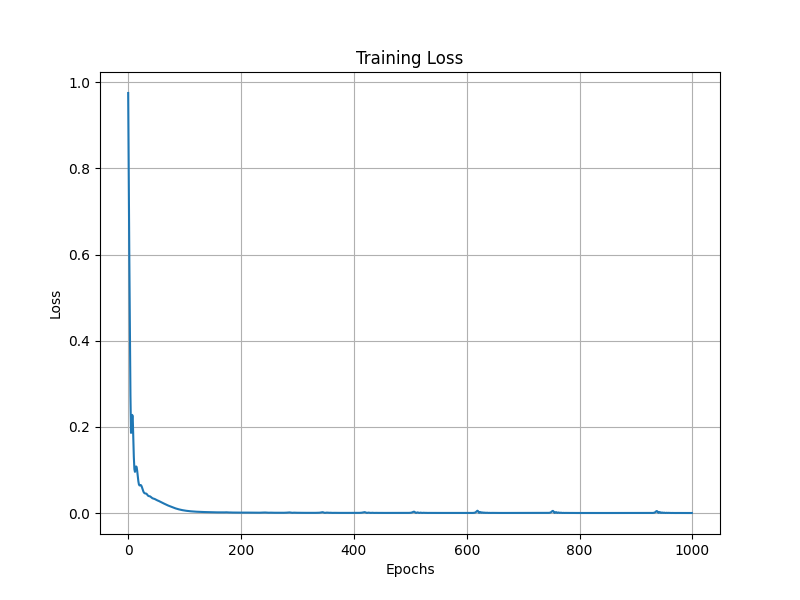

In [13]:
# Initialize the model
model = PP_NN()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 1000
losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

# Save trained model
torch.save(model.state_dict(), "PP_nn_model.pth")

### <div style= 'color: goldenrod'> Evaluate / compare TOV vs NN predictions for grid of Gamma2/Gamma3

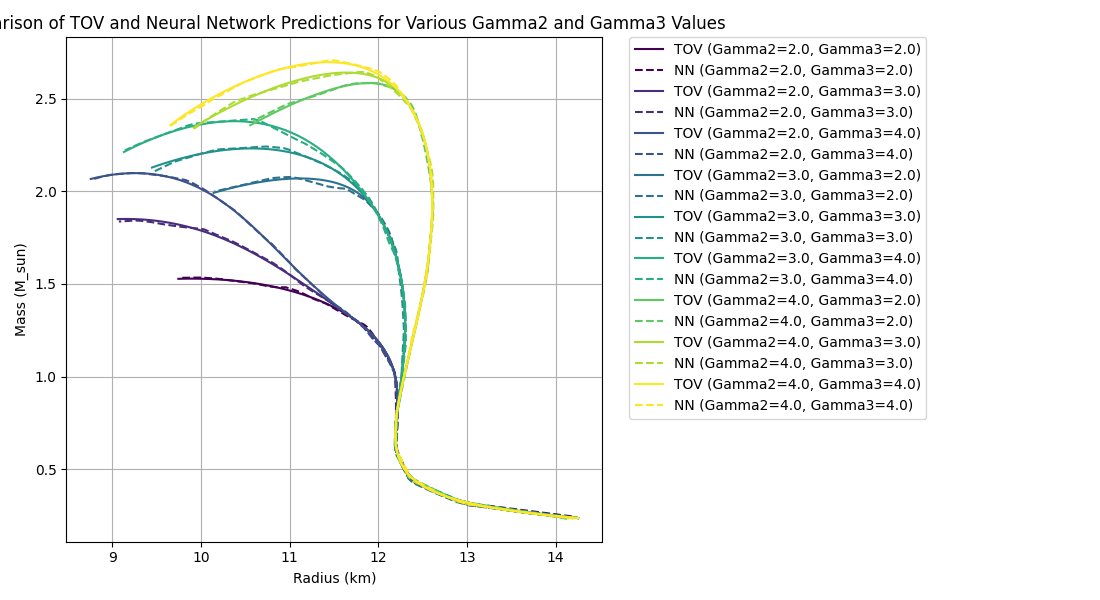

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Prepare ranges for Gamma2 and Gamma3
Gamma2_values = [2., 3., 4.]  
Gamma3_values = [2., 3., 4.]  

# Prepare the array for logrho_c values
logrho_c_array = np.linspace(14.5, 15.4, 100)

# Initialize lists to store results
predicted_mass = []
predicted_radius = []
original_mass = []
original_radius = []

# Iterate over all logp and Gamma1 values
for Gamma2 in Gamma2_values:
    for Gamma3 in Gamma3_values:
        # Store results for this logp and Gamma1 combination
        predicted_mass_single = []
        predicted_radius_single = []
        original_mass_single = []
        original_radius_single = []

        for logrho_c in logrho_c_array:
            # Prepare input tensor for prediction
            input_tensor = torch.tensor([[logrho_c, Gamma2, Gamma3]], dtype=torch.float32)
            
            # Normalize the input data using the training mean and std
            input_norm = (input_tensor - X_mean) / X_std
            
            # Make predictions with the trained model
            with torch.no_grad():
                prediction = model(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            prediction_np = prediction.detach().numpy()[0]  # Convert to NumPy and get the first element
            
            # Denormalize the predicted mass and radius
            mass_pred, radius_pred = prediction_np * y_std.numpy() + y_mean.numpy()
            
            # Calculate original mass and radius using TOV
            M_orig, R_orig = TOV(logrho_c, [34.495, 3.446, Gamma2, Gamma3])
            
            # Store the results
            predicted_mass_single.append(mass_pred)
            predicted_radius_single.append(radius_pred)
            original_mass_single.append(M_orig)
            original_radius_single.append(R_orig)

        # After iterating over logrho_c, store the results for each kappa, gamma pair
        predicted_mass.append(predicted_mass_single)
        predicted_radius.append(predicted_radius_single)
        original_mass.append(original_mass_single)
        original_radius.append(original_radius_single)

# Plotting Mass vs Radius for each kappa, gamma combination
plt.figure(figsize=(11, 6))

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(Gamma2_values) * len(Gamma3_values)))

# Iterate and assign the same color to TOV and NN prediction
for i, (Gamma2, Gamma3) in enumerate([(k, g) for k in Gamma2_values for g in Gamma3_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (Gamma2={Gamma2}, Gamma3={Gamma3})", linestyle='-', color=color)
    plt.plot(predicted_radius[i], predicted_mass[i], label=f"NN (Gamma2={Gamma2}, Gamma3={Gamma3})", linestyle='--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M_sun)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0)
plt.title("Comparison of TOV and Neural Network Predictions for Various Gamma2 and Gamma3 Values")
plt.tight_layout(rect=[0, 0, 0.6, 1])
plt.grid()
plt.show()